# Feature Selection and Modeling Notebook
This notebook demonstrates structured + embedding feature preprocessing, PCA, univariate feature selection, Random Forest modeling, stacking, and feature importance visualization.

In [1]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

In [2]:
# --- Load Data ---
embeddings_df = pd.read_csv('out/embeddings_processed.csv')
structured_df = pd.read_csv('out/data.csv')

# Convert embedding strings to float
embeddings_df = embeddings_df['embedding'].str.split(',', expand=True).astype(float)
embeddings_df.columns = [f'emb_{i}' for i in range(embeddings_df.shape[1])]

data = pd.concat([embeddings_df, structured_df], axis=1)
data = data.drop(columns=['cases.submitter_id'])

# Separate X and y
y = data['OS']
X = data.drop(columns=['OS'])

In [3]:
# --- Preprocessing ---
for col in X.columns:
    if X[col].dtype == 'object':
        X[col] = X[col].astype(str)

num_cols = X.select_dtypes(include=[np.number]).columns
cat_cols = X.select_dtypes(include=['object']).columns

# Impute numeric
num_imputer = SimpleImputer(strategy='median')
X[num_cols] = num_imputer.fit_transform(X[num_cols])

# Impute categorical
if len(cat_cols) > 0:
    cat_imputer = SimpleImputer(strategy='most_frequent')
    X[cat_cols] = pd.DataFrame(cat_imputer.fit_transform(X[cat_cols]), columns=cat_cols, index=X.index)

# Encode categoricals
le_dict = {}
for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    le_dict[col] = le

In [4]:
# --- Define Feature Groups ---
embedding_cols = [col for col in X.columns if col.startswith('emb_')]
data_cols = [col for col in X.columns if not col.startswith('emb_')]
print(f'Embedding features: {len(embedding_cols)}, Structured features: {len(data_cols)}')

Embedding features: 768, Structured features: 19


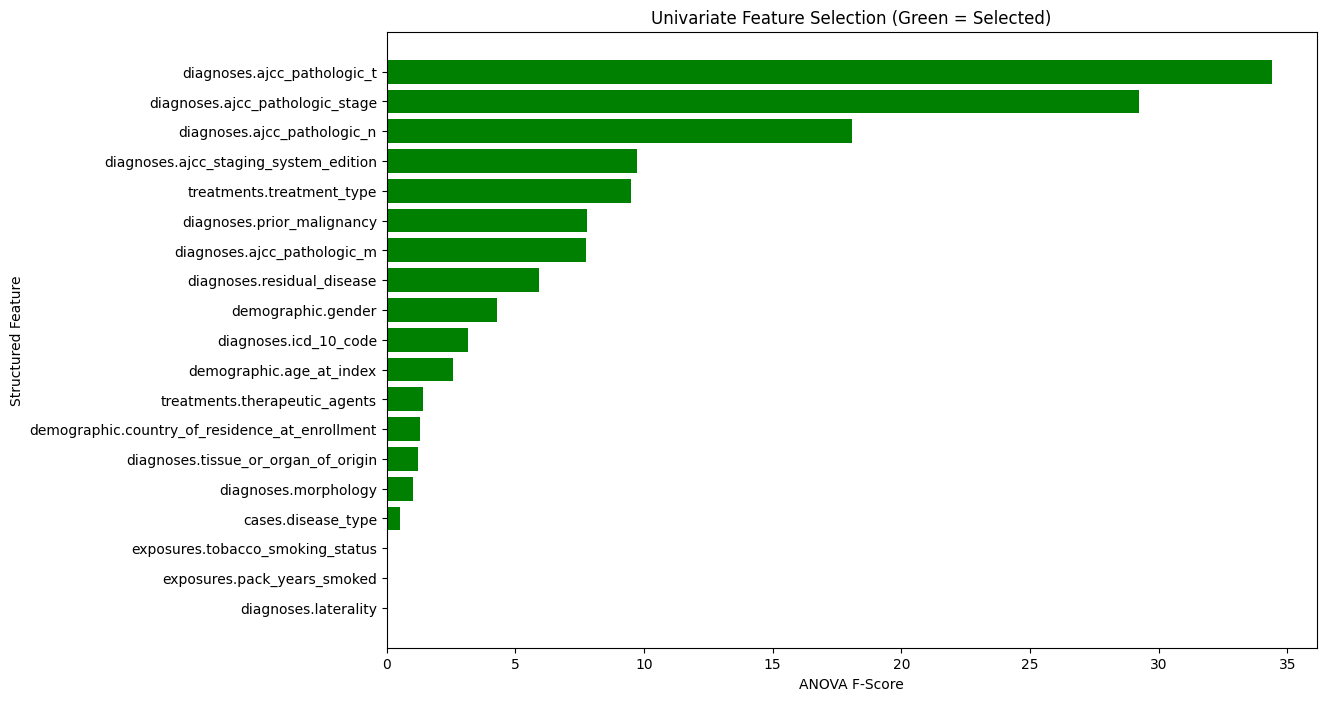

In [5]:
# --- Univariate Feature Selection ---
univariate_selector = SelectKBest(f_classif, k='all')
univariate_selector.fit(X[data_cols], y)
scores = univariate_selector.scores_
selected = univariate_selector.get_support()

feature_scores_df = pd.DataFrame({
    'Feature': data_cols,
    'F-score': scores,
    'Selected': selected
}).sort_values('F-score', ascending=True)

# Plot univariate scores
plt.figure(figsize=(12,8))
plt.barh(feature_scores_df['Feature'], feature_scores_df['F-score'],
         color=['green' if s else 'gray' for s in feature_scores_df['Selected']])
plt.xlabel('ANOVA F-Score')
plt.ylabel('Structured Feature')
plt.title('Univariate Feature Selection (Green = Selected)')
plt.show()

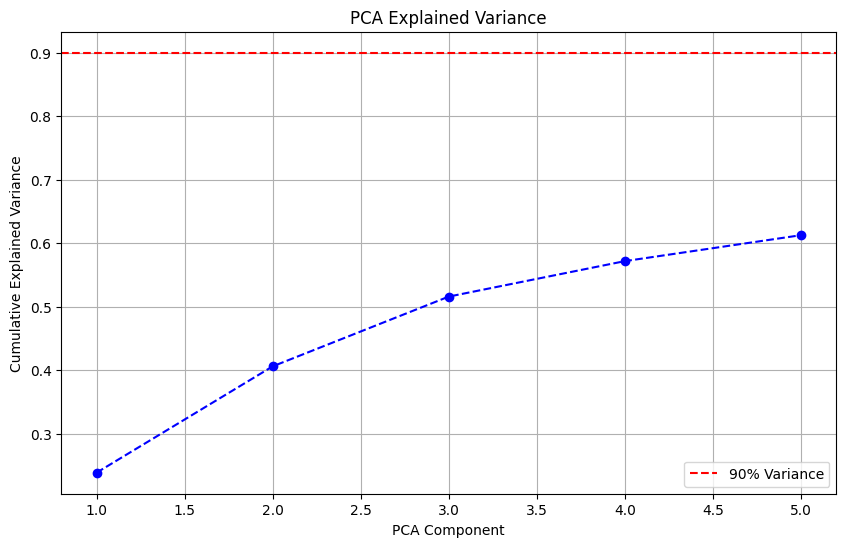

In [6]:
# --- PCA on Embeddings ---
scaler_emb = StandardScaler()
X_emb_scaled = scaler_emb.fit_transform(X[embedding_cols])

pca = PCA(n_components=5)  # choose number of components
X_pca = pca.fit_transform(X_emb_scaled)

# Explained variance
explained_variance = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(10,6))
plt.plot(range(1,len(explained_variance)+1), explained_variance, marker='o', linestyle='--', color='blue')
plt.axhline(y=0.90, color='red', linestyle='--', label='90% Variance')
plt.xlabel('PCA Component')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
# --- Combine PCA and structured features ---
X_combined = np.hstack([X_pca, X[data_cols].values])
all_feature_names = [f'PCA_{i+1}' for i in range(X_pca.shape[1])] + data_cols

In [8]:
# --- Random Forest on Combined Data ---
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf_model, X_combined, y, cv=skf, scoring='roc_auc', n_jobs=-1)
print(f'Mean CV ROC AUC: {cv_scores.mean():.4f}')

Mean CV ROC AUC: 0.6941


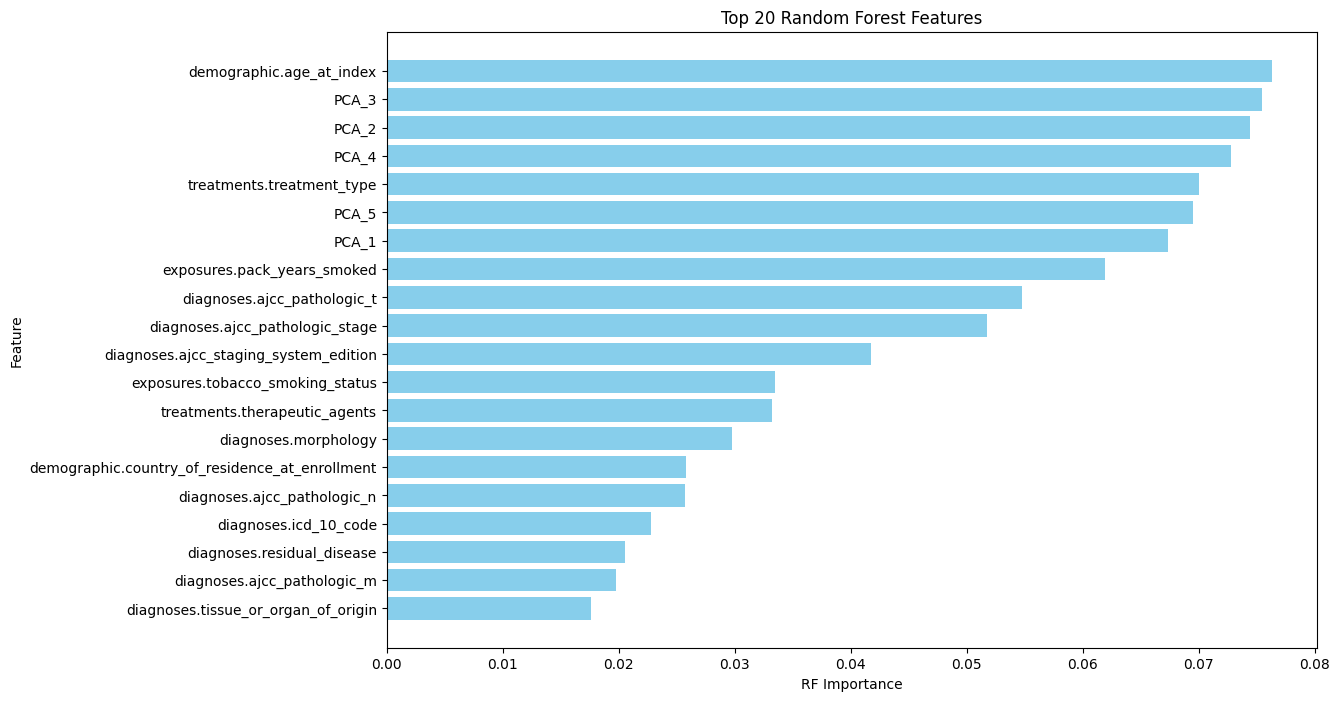

In [9]:
# --- Fit RF on full combined data and get feature importances ---
rf_model.fit(X_combined, y)
importances = rf_model.feature_importances_
feature_importances_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=True)

# Plot top 20 features
plt.figure(figsize=(12,8))
plt.barh(feature_importances_df['Feature'].tail(20), feature_importances_df['Importance'].tail(20), color='skyblue')
plt.xlabel('RF Importance')
plt.ylabel('Feature')
plt.title('Top 20 Random Forest Features')
plt.show()

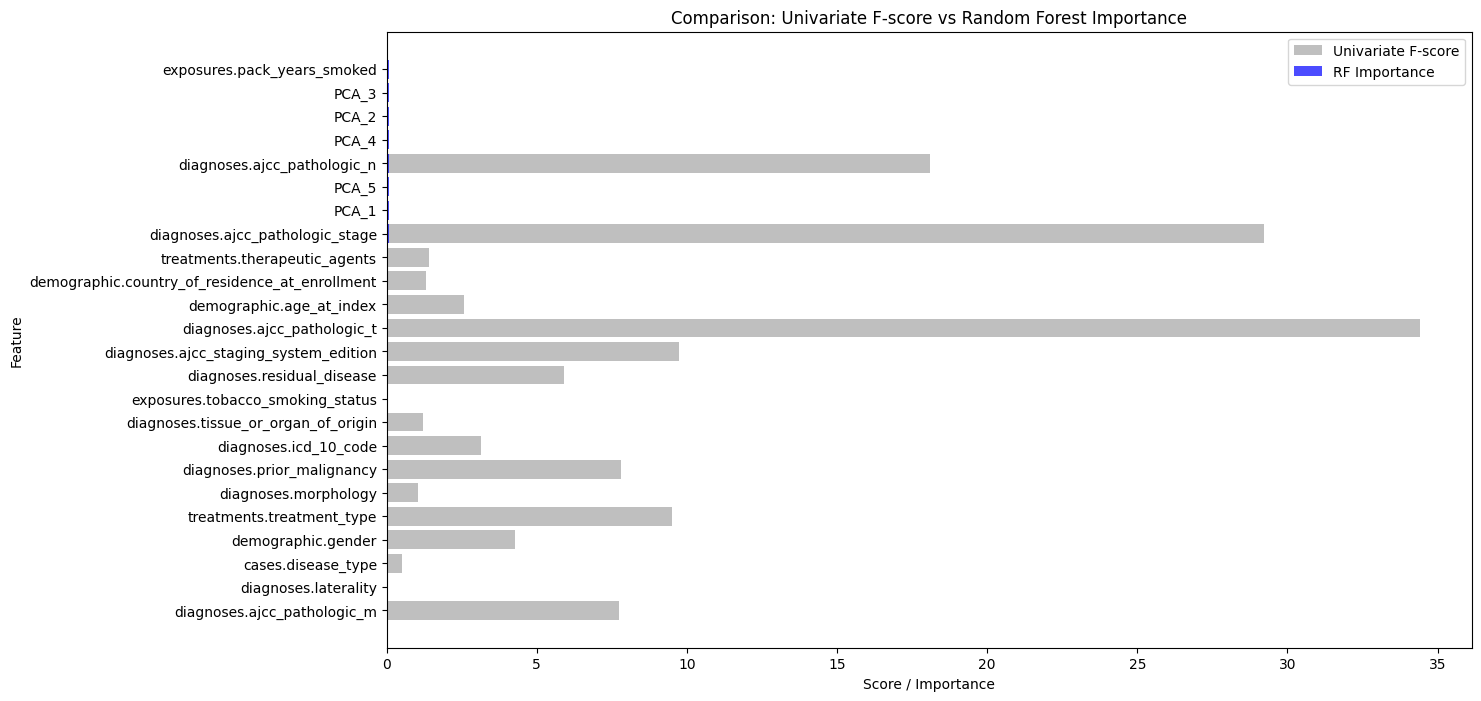

In [10]:
# --- Compare Univariate vs RF Importances ---
combined_plot_df = pd.DataFrame({
    'Feature': feature_scores_df['Feature'].tolist() + [f'PCA_{i+1}' for i in range(X_pca.shape[1])],
    'Univariate_F': list(feature_scores_df['F-score']) + [0]*X_pca.shape[1],
    'RF_Importance': list(importances[-len(data_cols):]) + list(importances[:X_pca.shape[1]])
})
combined_plot_df = combined_plot_df.sort_values('RF_Importance', ascending=True)

plt.figure(figsize=(14,8))
plt.barh(combined_plot_df['Feature'], combined_plot_df['Univariate_F'], color='gray', alpha=0.5, label='Univariate F-score')
plt.barh(combined_plot_df['Feature'], combined_plot_df['RF_Importance'], color='blue', alpha=0.7, label='RF Importance')
plt.xlabel('Score / Importance')
plt.ylabel('Feature')
plt.title('Comparison: Univariate F-score vs Random Forest Importance')
plt.legend()
plt.show()